In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 22 01:50:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
!ls

drive  sample_data


In [ ]:
!/content/drive/MyDrive

/bin/bash: /content/drive/MyDrive: Is a directory


In [ ]:
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving att_unet.py to att_unet.py
Saving crf.py to crf.py
Saving m_resunet.py to m_resunet.py
Saving metrics.py to metrics.py
Saving mobilenetv2_unet.py to mobilenetv2_unet.py
Saving model.py to model.py
Saving net.py to net.py
Saving resnet50_unet.py to resnet50_unet.py
Saving resunet.py to resunet.py
Saving resunet++_pytorch.py to resunet++_pytorch.py
Saving train.py to train.py
Saving tta.py to tta.py
Saving unet.py to unet.py
Saving utils.py to utils.py


In [ ]:
#uploaded = files.upload()

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from model_UNet import build_unet
from metrics import dice_coef, iou, jacard_coef, f1_score

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers

In [ ]:
H = 736
W = 736

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


In [ ]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images", "*.tif")))
    masks = sorted(glob(os.path.join(path, "masks", "*.tif")))
    size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory to save files """
    create_dir("files")

    """ Hyperparaqmeters """
    batch_size = 8
    lr = 1e-4   ## 0.0001
    num_epochs = 100
    model_path = "/content/drive/MyDrive/iPS_Field7A/files/U-NET_iPSField7.h5"
    csv_path = "/content/drive/MyDrive/iPS_Field7A/files/UNET_iPSField7data.csv"

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/iPS_Field7A/data/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffle(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    # ds = (1, 2, 3, 4, 5)
    # bs = 2
    # n = len(ds)//bs = 2
    # [1, 2], [3, 4], [1]

    train_steps = (len(train_x)//batch_size)
    valid_steps = (len(valid_x)//batch_size)

    if len(train_x) % batch_size != 0:
        train_steps += 1

    if len(valid_x) % batch_size != 0:
        valid_steps += 1

Train: 2238 - 2238
Valid: 279 - 279
Test: 279 - 279


In [16]:
unet_model = build_unet((H, W, 3))
unet_model.compile(loss="binary_crossentropy", optimizer=Adam(lr), 
              metrics=['accuracy',dice_coef, f1_score, jacard_coef, Recall(), Precision()])
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path)
    ]
print(unet_model.summary())

start1 = datetime.now() 
unet_history = unet_model.fit(train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks)
stop1 = datetime.now()
#Execution time of the model 
execution_time_Unet = stop1-start1
print("Execution time is: ", execution_time_Unet)

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 576, 576, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 576, 576, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 576, 576, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [17]:
unet_model.save('/content/drive/MyDrive/iPS_Field7A/files/U-NET_iPSField7.h5')

In [18]:
import pandas as pd    
unet_history_df = pd.DataFrame(unet_history.history) 

In [19]:
with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)
    

In [20]:
#Check history plots, one model at a time
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
history = unet_history


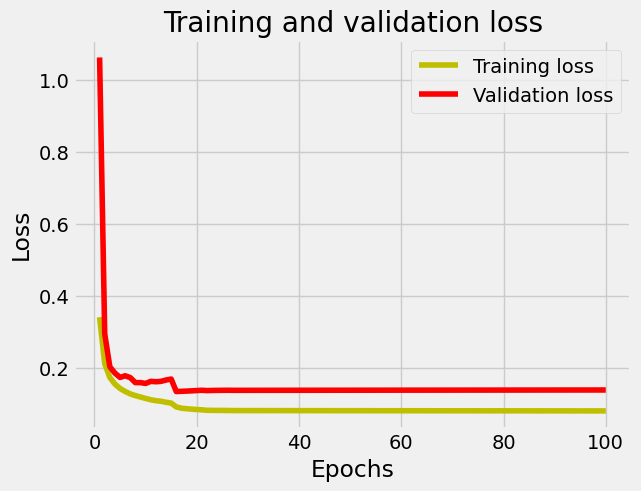

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

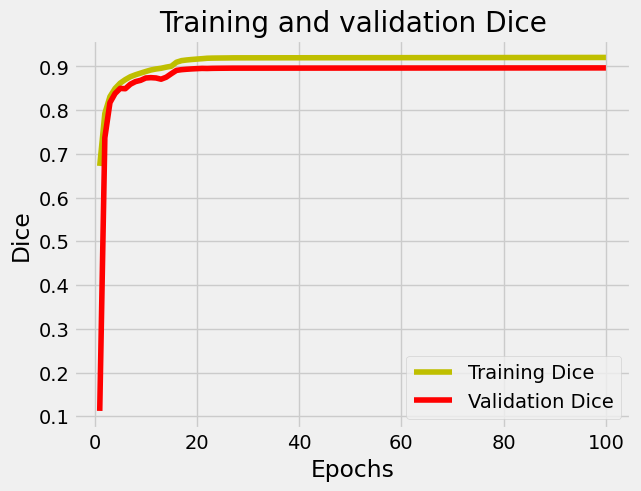

In [22]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']
plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

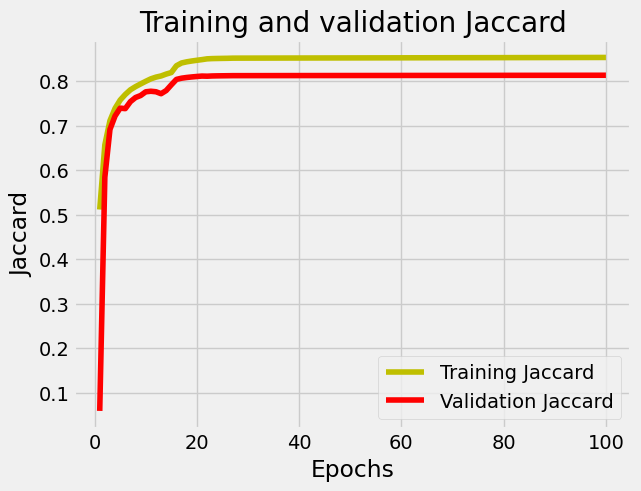

In [23]:
acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']
plt.plot(epochs, acc, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc, 'r', label='Validation Jaccard')
plt.title('Training and validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.show()



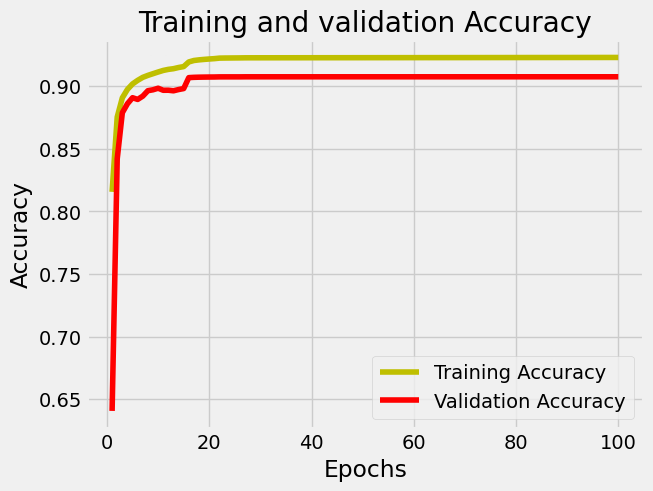

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



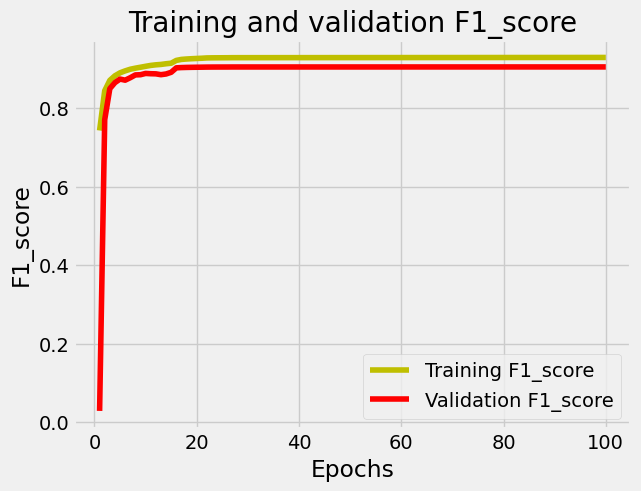

In [25]:
acc = history.history['f1_score']
val_acc = history.history['val_f1_score']
plt.plot(epochs, acc, 'y', label='Training F1_score')
plt.plot(epochs, val_acc, 'r', label='Validation F1_score')
plt.title('Training and validation F1_score')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()
plt.show()



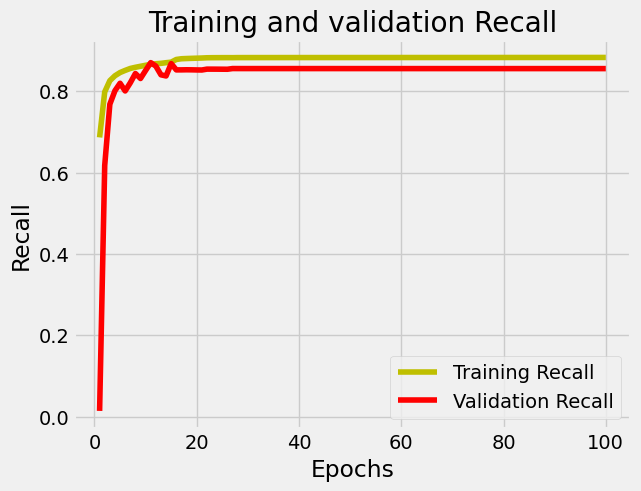

In [26]:
acc = history.history['recall']
val_acc = history.history['val_recall']
plt.plot(epochs, acc, 'y', label='Training Recall')
plt.plot(epochs, val_acc, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

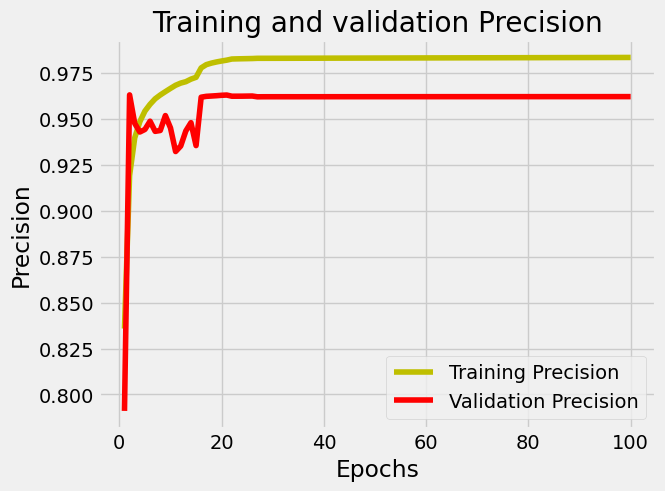

In [27]:
acc = history.history['precision']
val_acc = history.history['val_precision']
plt.plot(epochs, acc, 'y', label='Training Precision')
plt.plot(epochs, val_acc, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()